<a href="https://colab.research.google.com/github/ZahraDehghani99/PhD-Task_Security-testing-USI-/blob/main/PhD_Task_MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Train MNIST Digits classification

In this phase we want to Train a digit classifier on MNIST dataset using Pytorch framework. For this aim, we use famous CNN architecure whose name is LeNet. We want to reach the accuracy of at least 80%.

In the beginning we import required libraries. The most important library that we used is `torch`, which offers us to use Pytorch for training and testing our model.

## Import required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

We should mount google drive to save and load our model from it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')     

Mounted at /content/drive


In this cell we specify our device which can be `cpu` or `cuda`. It uses for transfer model and other stuff to device (especially cude for improving train speed.). 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the MNIST dataset

We need to load the MNIST dataset. We can use PyTorch's built-in `torchvision.datasets` module to download and load the dataset.

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_dataset = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='data/', train=False, transform=ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 99478179.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97768921.57it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26477987.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22760488.37it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(f'type of first element of train_dataset : {type(train_dataset[0])}')

type of first element of train_dataset : <class 'tuple'>


In [ ]:
print(f'shape of first element of tuple: {train_dataset[0][0].shape} and seconde element of tuple is int and its value is : {train_dataset[0][1]}')

shape of first element of tuple: torch.Size([1, 28, 28]) and seconde element of tuple is int and its value is : 5


Next we should specify the value of our parameters and hyperparameters.

In [ ]:
batch_size = 128
learning_rate = 0.001
num_epochs = 10

Next we should create train loader and test loader in order to iterate over batches of data. It's worth to mention that we should set `shuffle=True` in train loader. It prevents model learning the order of labels in dataset. On the other hand we should set `shuffle=False` in test loader, because when we are in test phase, it does not have effect on model any more.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
print(f'length of train_dataset is : {len(train_dataset)} and length of train_loader is : {len(train_loader)}')
print(f'length of test_dataset is : {len(test_dataset)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 60000 and length of train_loader is : 469
length of test_dataset is : 10000 and length of test_loader is : 79


In this cell we want to watch data distribution. As we can see we have balanced dataset.

In [ ]:
classes = [label for _, label in train_dataset]
y = pd.DataFrame(classes)
y.columns = ['label']

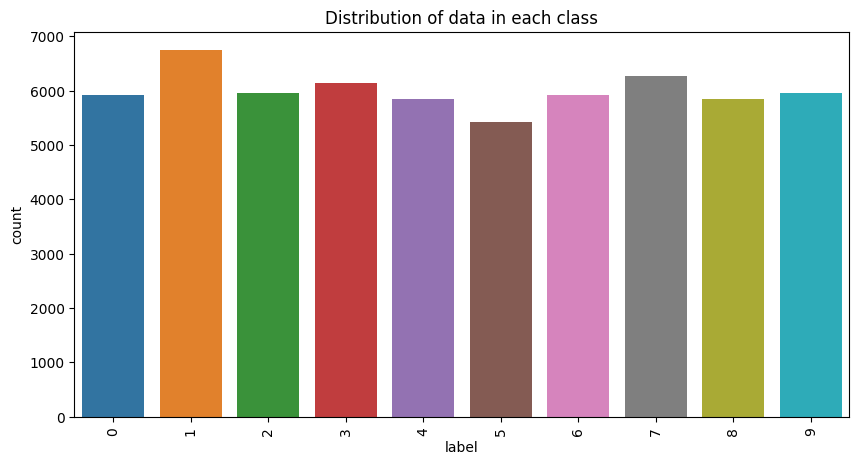

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x="label", data=y)
plt.title("Distribution of data in each class")
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=15)
plt.show()

In [ ]:
examples = iter(train_loader)
#unpack examples
samples , labels = next(examples)
print(f'samples shape : {samples.shape} ,labels shape : {labels.shape}')

samples shape : torch.Size([128, 1, 28, 28]) ,labels shape : torch.Size([128])


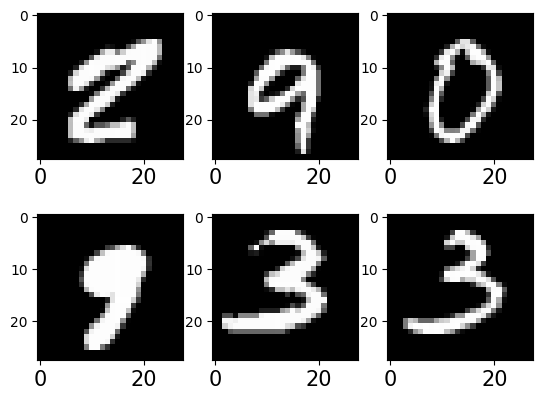

In [ ]:
for i in range(6):
  plt.subplot(2,3, i+1)
  plt.imshow(samples[i][0],cmap='gray')

##  Define the LeNet architecture

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Define the loss function and optimizer

We should initiate model, define criterion and optimizer.

In [ ]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
n_total_step = len(train_loader)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


We use following function in training in order to calculate accuracy of each epoch.

In [ ]:
# Define a funciton to calculate accuracy for multi class classification model
def multi_class_acc(y_pred, y_act):

  y_pred_softmax = torch.softmax(y_pred, 1)
  _, y_pred_tag = torch.max(y_pred_softmax,1)

  correct = (y_pred_tag == y_act).float()  # Show which elements are the same with 1
  acc = correct.sum()/len(correct)
  acc = torch.round(acc * 100)

  return acc

## Train the network

For the aim of wathing the process of trianing model as it trains, we use `tensorboard`.

In [ ]:
from datetime import datetime

# Getting the current date and time
dt = datetime.now()
str_date_time = dt.strftime("%Y%m%d-%H%M%S")

In [ ]:
str_date_time

'20230427-081533'

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=runs

<img style="float: left;" src='https://drive.google.com/uc?id=1oewqtl0Zt0osHa0nDvm_ZPwjIFD6bIPF' width="500" height="300">
<img style="float: right;" src='https://drive.google.com/uc?id=1dbjnPiCQAnxhb_leKOvu4ZQIAxoJn09p' width="500" height="300">

## image of tensorboarad

In this cell we train our model and save train loss and accuracy in each epoch for plotting diagrams.

In [ ]:
train_loss = []
train_acc = []

for epoch in range(num_epochs):

  train_epoch_loss = 0
  train_epoch_acc = 0
  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)
  
  for i , (img, label) in loop:

    # transfer tensor to device
    img = img.to(device)
    label = label.to(device)

    # forward pass
    y_pred = model(img)
    loss_train = criterion(y_pred, label)
    acc_train = multi_class_acc(y_pred, label)

    # backward pass
    optimizer.zero_grad()  # clear the gradients
    loss_train.backward()
    optimizer.step()       # update model weights

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item() 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))
     
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch * n_total_step + i)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch * n_total_step + i)
  writer.flush()

  # Upgrade progress bar
  loop.set_description(f'Epoch : [{epoch + 1}/{num_epochs}]')
  loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item())

As we can see loss function of the model is decreasing during training.

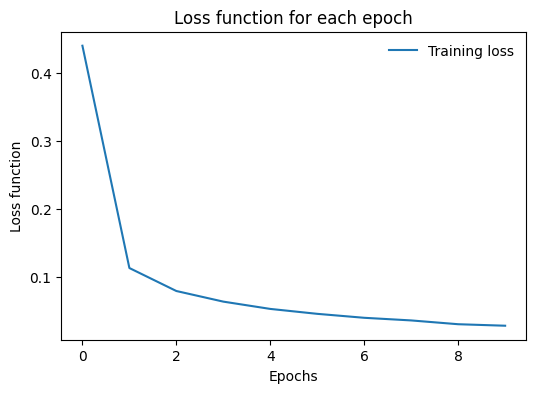

In [ ]:
#Training loss
plt.figure(figsize = (6, 4))
plt.plot(train_loss, label='Training loss')
plt.legend(frameon=False)
plt.title("Loss function for each epoch") 
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.show()

As we can see, diagram of accuracy for each epoch is as expected and it's increasing.

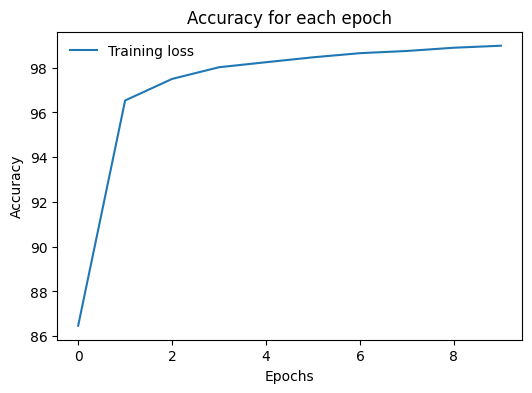

In [ ]:
#Training accuracy
plt.figure(figsize = (6, 4))
plt.plot(train_acc, label='Training loss')
plt.legend(frameon=False)
plt.title("Accuracy for each epoch") 
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Test the network

In this section we should test our trained model on test set.

In [ ]:
classes = train_dataset.classes

In [ ]:
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
y_pred_test = []
y_actual_test = []

model.eval()
with torch.no_grad():
  n_true = 0
  n_total = 0

  for im, lbs in test_loader:
    im = im.to(device)
    lbs = lbs.to(device)
    output = model(im)

    _, y_predtest = torch.max(output,1)

    n_true += (y_predtest == lbs).sum()
    n_total += lbs.size(0) 

    for i in range(len(y_predtest)):
      y_pred_test.append(y_predtest[i])
      y_actual_test.append(lbs[i])

  print(f'accuracy of network on the {len(test_dataset)} images is : {(n_true/n_total) *100}')

accuracy of network on the 10000 images is : 98.6199951171875


## Confusion matrix

In this section we will print confusion matrix of the model on test set to understand operation of  model on test set for each class.

In [ ]:
y_actual_test = [i.cpu() for i in y_actual_test]
y_pred_test = [i.cpu() for i in y_pred_test]

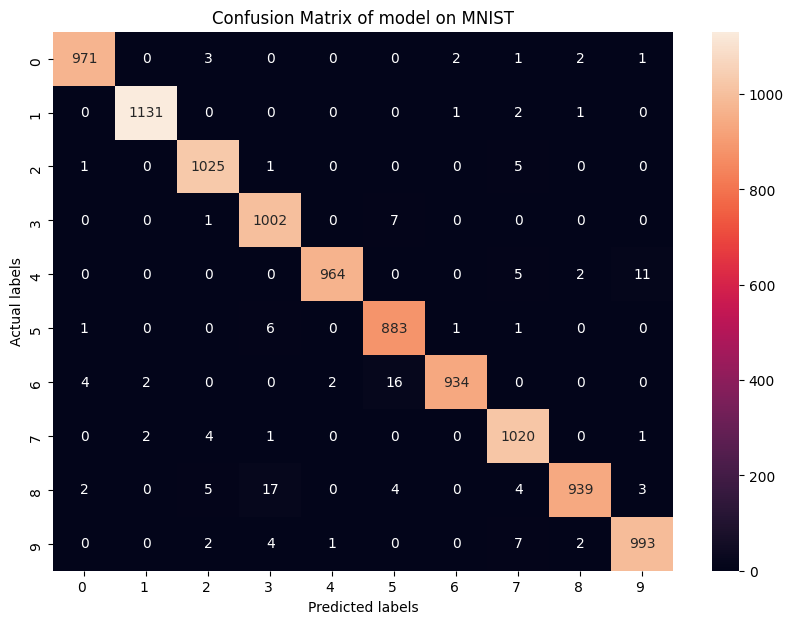

In [ ]:
from sklearn import metrics
import seaborn as sns

plt.figure(figsize = (10, 7))
ax= plt.subplot()
cnf_matrix = metrics.confusion_matrix(y_actual_test, y_pred_test)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

confusion_matrix_tags = [i.split("-")[0] for i in classes]
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix of model on MNIST')
ax.xaxis.set_ticklabels(confusion_matrix_tags)
ax.yaxis.set_ticklabels(confusion_matrix_tags);

## Classification report

Classification shows accuracy and other evaluation criteria on each class.

In [ ]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       1.00      0.98      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.97      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.96      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
torch.save(model,f'/content/drive/MyDrive/Task/MNIST_model/model_mnist_{str_date_time}')

In [ ]:
print(f'name of last model : model_mnist_{str_date_time}')

name of last model : model_mnist_20230427-081533


# 2. Attack to Classifier

In this phase we should load our trained model and test it on attacked dataset to show its accuracy . We will define two attack functions (fgsm and pgd). 

## Load the trained model

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Load the trained model
model = LeNet()
model = torch.load('/content/drive/MyDrive/Task/MNIST_model/model_mnist_20230427-081533')
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Load MNIST test dataset

In [ ]:
# Load the test data
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 71404153.90it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 90942713.08it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21877355.18it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20506489.52it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of test_dataset is : 10000 and length of test_loader is : 10000


## Define attack algorithms

Let's define attack algorithms.

In [ ]:
def fgsm_attack(model, data, target, epsilon):
    # Create a new tensor that is a leaf variable with the same values as data
    input_data = data.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(input_data)
    init_pred = output.max(1, keepdim=True)[1]

    # If the initial prediction is incorrect, do not bother with the attack
    if init_pred.item() != target.item():
        return input_data.detach()

    # Calculate the loss
    loss = torch.nn.functional.nll_loss(output, target)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Collect the gradient of the loss with respect to the input
    data_grad = input_data.grad.data

    # Call sign on the gradients
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon * sign_data_grad.clamp(min=-1, max=1)

    # Clip the perturbation to be within the valid image range
    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data.detach()



def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    # Generate a random initial perturbation within the epsilon range
    delta = torch.rand_like(images, requires_grad=True)
    delta.data = delta.data * 2 * epsilon - epsilon

    # Define the range for pixel clipping
    clip_min = 0
    clip_max = 1

    # PGD attack loop
    for i in range(num_iter):
        # Calculate the gradient of the loss with respect to the perturbation
        loss = torch.nn.functional.nll_loss(model(images + delta), labels)
        loss.backward()
        grad = delta.grad.detach()

        # Project the perturbation onto the epsilon L-infinity ball
        delta.data = delta.data + alpha * torch.sign(grad)
        delta.data = torch.max(torch.min(delta.data, images + epsilon - clip_min), images - epsilon - clip_max)
        delta.data = torch.clamp(delta.data, clip_min - images, clip_max - images)

        # Reset the gradients
        delta.grad.zero_()

    # Create the perturbed image by adding the perturbation to the input image
    perturbed_image = torch.clamp(images + delta.detach(), clip_min, clip_max)

    return perturbed_image


## Define accuracy function

Let's define accuracy function.

In [ ]:
# evaluation of model 
def calculate_accuracy(model, dataloader):
  model.eval()  # set the model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

## Calculate accuracy before and after applying attack 

In this secton we perform different attack functions on clean test set and compare the evalluation of model on clean testset and attacked testset. As we can see, the performance of model on attacked testset is lower than clean testset.

In [ ]:
# Evaluate the model accuracy on the clean test data
clean_accuracy = calculate_accuracy(model, test_loader)
print(f'Accuracy of model on clean testset: {clean_accuracy:.2f}%')


######################################################### FGSM attack ######################################################### 
# Generate adversarial examples using the FGSM attack
epsilon = 0.1

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
adversarial_accuracy = calculate_accuracy(model, adv_examples)
print(f'Accuracy of model on attacked testset (FGSM attack): {adversarial_accuracy:.2f}%')


######################################################### PGD attack ######################################################### 
# Generate adversarial examples using the PGD attack
epsilon=0.3
alpha=0.01
num_iter=40

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
adversarial_accuracy = calculate_accuracy(model, adv_examples)
print(f'Accuracy of model on attacked testset (PGD attack): {adversarial_accuracy:.2f}%')

Accuracy of model on clean testset: 98.62%
Accuracy of model on attacked testset (FGSM attack): 80.00%
Accuracy of model on attacked testset (PGD attack): 0.00%


## Visualize images before and after attack

### PGD attack

In [ ]:
def visualise_PGD_adversarial_examples(model, x, y, epsilon, alpha, num_iter):
    x = x.unsqueeze(0)
    y = torch.tensor(y, dtype=torch.int64)
    y = y.unsqueeze(0)

    x = x.to(device)
    y = y.to(device)

    x_adv_l2 = pgd_attack(model, x, y, epsilon, alpha, num_iter)
    
    y_pred = model(x)
    y_pred_l2 = model(x_adv_l2)
    
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title(
        f'Natural, '
        f'P({ y_pred.argmax(dim=1).item()}) = '
        f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(x_adv_l2[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title(
        f'$L^2$ adversary, '
        f'eps={epsilon}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_l2.softmax(dim=1)[0, y_pred_l2.argmax(dim=1).item()].item(), 3)}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.show()

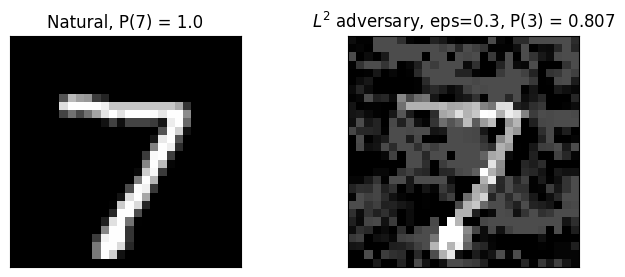

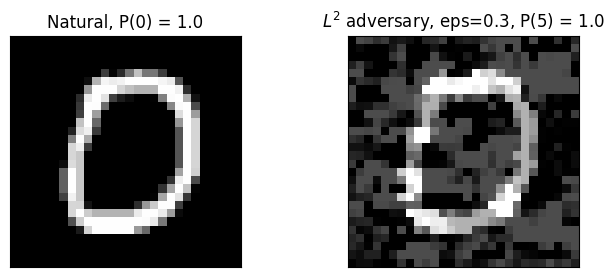

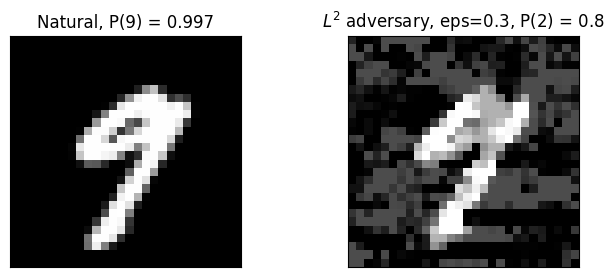

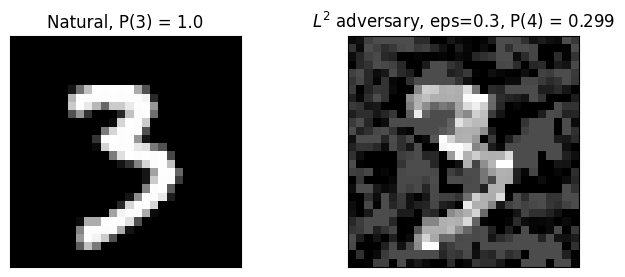

In [ ]:
epsilon=0.3
alpha=0.01
num_iter=40

visualise_PGD_adversarial_examples(model, *test_data[0], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[10], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[20], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[30], epsilon, alpha, num_iter)

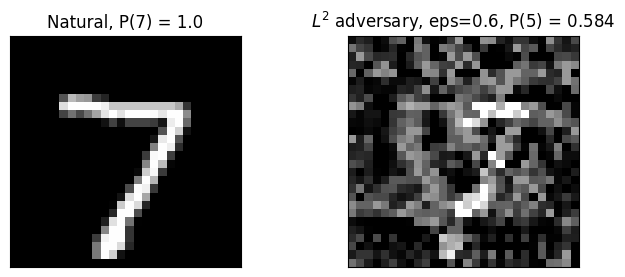

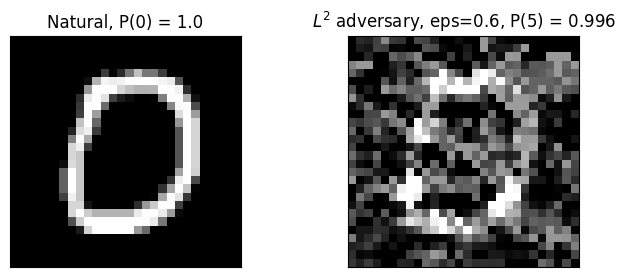

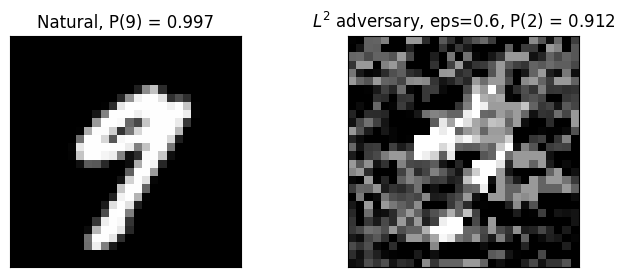

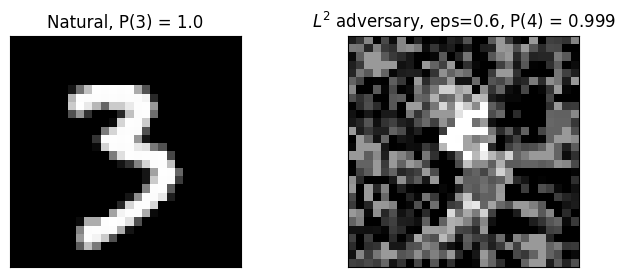

In [ ]:
epsilon= 0.6
alpha=0.01
num_iter= 40

visualise_PGD_adversarial_examples(model, *test_data[0], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[10], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[20], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[30], epsilon, alpha, num_iter)

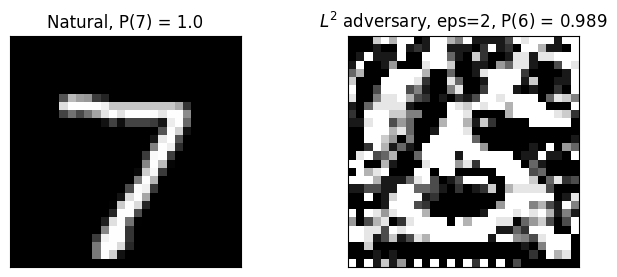

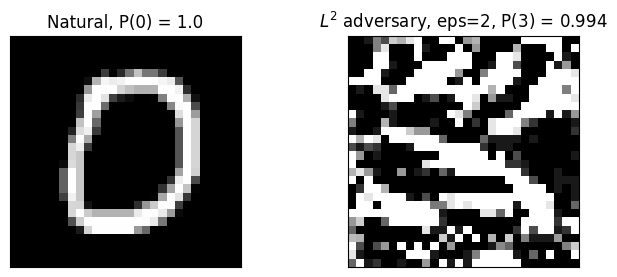

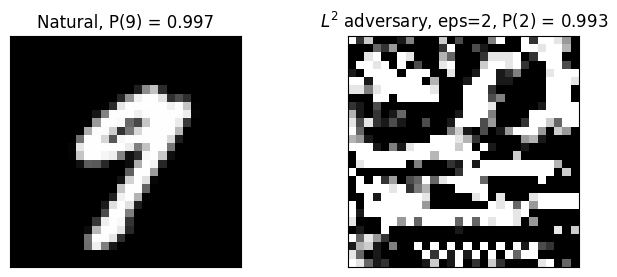

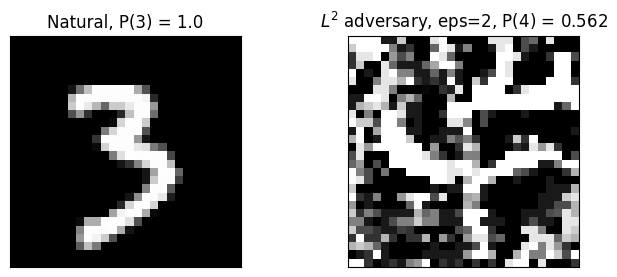

In [ ]:
epsilon= 2
alpha=0.1
num_iter= 120

visualise_PGD_adversarial_examples(model, *test_data[0], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[10], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[20], epsilon, alpha, num_iter)
visualise_PGD_adversarial_examples(model, *test_data[30], epsilon, alpha, num_iter)

### FGSM attack

In [ ]:
def visualise_FGSM_adversarial_examples(model, x, y, epsilon):
    x = x.unsqueeze(0)
    y = torch.tensor(y, dtype=torch.int64)
    y = y.unsqueeze(0)

    x = x.to(device)
    y = y.to(device)

    x_adv_l2 = fgsm_attack(model, x, y, epsilon)
    
    y_pred = model(x)
    y_pred_l2 = model(x_adv_l2)
    
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title(
        f'Natural, '
        f'P({ y_pred.argmax(dim=1).item()}) = '
        f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(x_adv_l2[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title(
        f'FGSM adversary, '
        f'eps={epsilon}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_l2.softmax(dim=1)[0, y_pred_l2.argmax(dim=1).item()].item(), 3)}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.show()

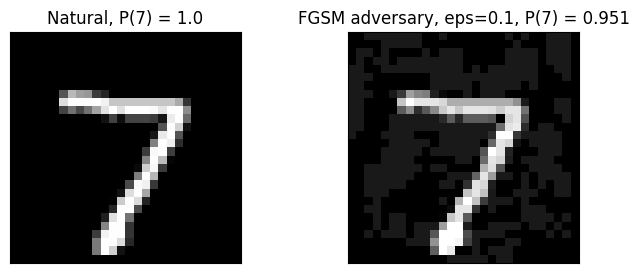

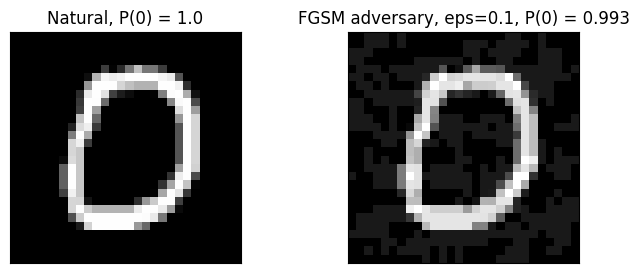

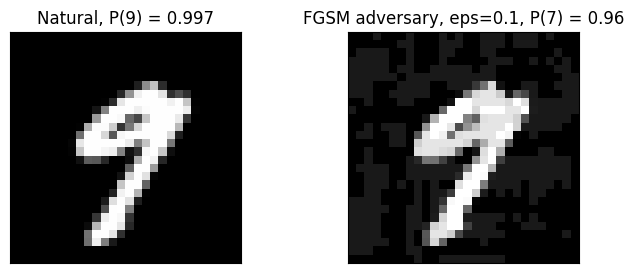

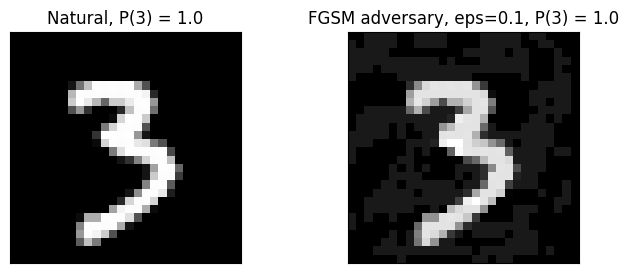

In [ ]:
epsilon=0.1

visualise_FGSM_adversarial_examples(model, *test_data[0], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[10], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[20], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[30], epsilon)

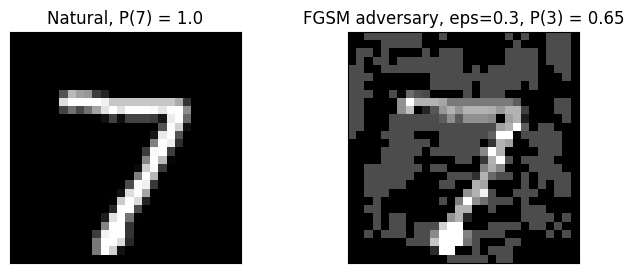

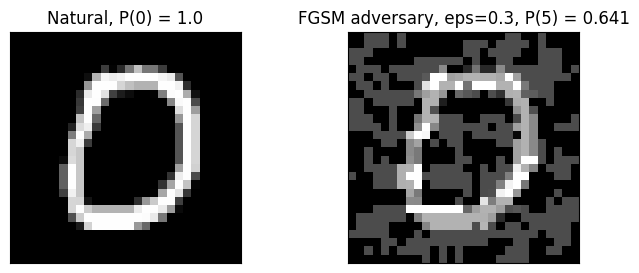

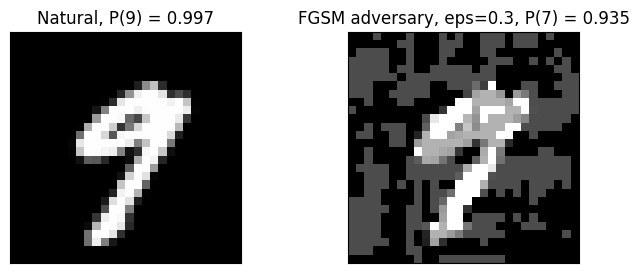

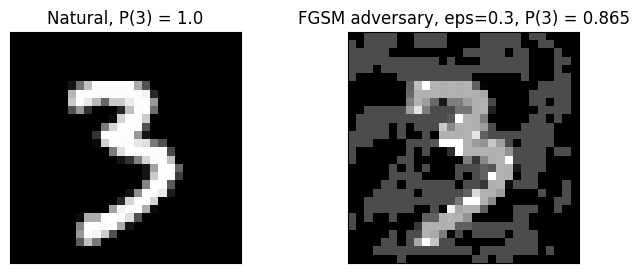

In [ ]:
epsilon=0.3

visualise_FGSM_adversarial_examples(model, *test_data[0], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[10], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[20], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[30], epsilon)

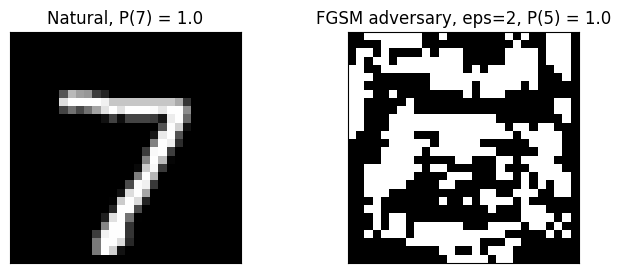

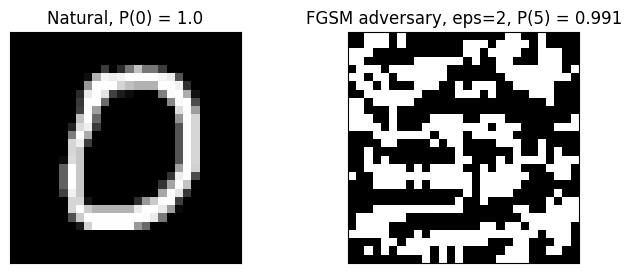

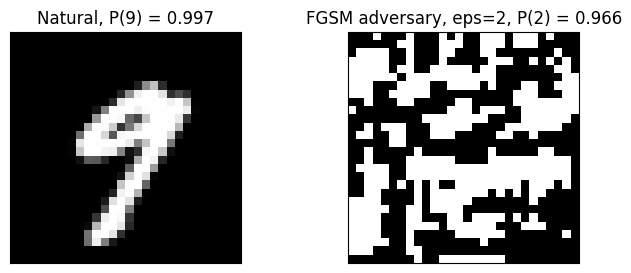

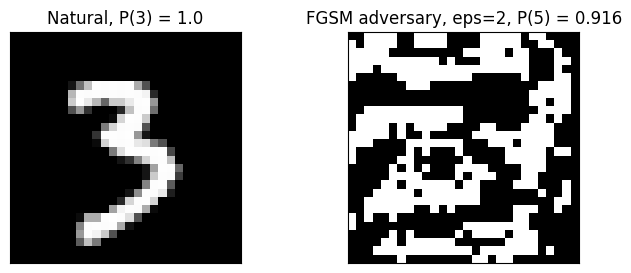

In [ ]:
epsilon=2

visualise_FGSM_adversarial_examples(model, *test_data[0], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[10], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[20], epsilon)
visualise_FGSM_adversarial_examples(model, *test_data[30], epsilon)

## Evaluate model against adversary

In [ ]:
!pip install -q olympic

Olympic implements a Keras-like API for PyTorch.

In [ ]:
import olympic

def evaluate_against_PGD_adversary(model, epsilon, alpha, num_iter):
    total = 0
    acc = 0
    for x, y in test_loader:
        total += x.size(0)
        

        x_adv = pgd_attack(model, x.to(device), y.to(device), epsilon, alpha, num_iter)

        
        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(device), y_pred) * x.size(0)

    return (acc/total) * 100

def evaluate_against_FGSM_adversary(model, epsilon):
    total = 0
    acc = 0
    for x, y in test_loader:
        total += x.size(0)
        

        x_adv = fgsm_attack(model, x.to(device), y.to(device), epsilon)

        
        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(device), y_pred) * x.size(0)

    return (acc/total) * 100


In [ ]:
fgsm_attack_range = [0, .05, .1, .15, .2, .25, .3]
fgsm_acc = []

for eps in fgsm_attack_range:
  acc = evaluate_against_FGSM_adversary(model, epsilon=eps)
  fgsm_acc.append(acc)
  print(f'Epsilon: {eps:.2f} => Test accuracy: {acc:.2f}')

Epsilon: 0.00 => Test accuracy: 98.62
Epsilon: 0.05 => Test accuracy: 93.70
Epsilon: 0.10 => Test accuracy: 80.00
Epsilon: 0.15 => Test accuracy: 56.07
Epsilon: 0.20 => Test accuracy: 28.58
Epsilon: 0.25 => Test accuracy: 11.31
Epsilon: 0.30 => Test accuracy: 3.79


In [ ]:
alpha=0.1
num_iter= 40
pgd_attack_range = np.arange(0.0, 0.52, 0.1)
pgd_acc = []

for eps in pgd_attack_range:
  acc = evaluate_against_PGD_adversary(model, eps, alpha, num_iter)
  pgd_acc.append(acc)
  print(f'Epsilon: {eps:.2f} => Test accuracy: {acc:.2f}')

Epsilon: 0.00 => Test accuracy: 77.24
Epsilon: 0.10 => Test accuracy: 22.12
Epsilon: 0.20 => Test accuracy: 0.25
Epsilon: 0.30 => Test accuracy: 0.00
Epsilon: 0.40 => Test accuracy: 0.00
Epsilon: 0.50 => Test accuracy: 0.00


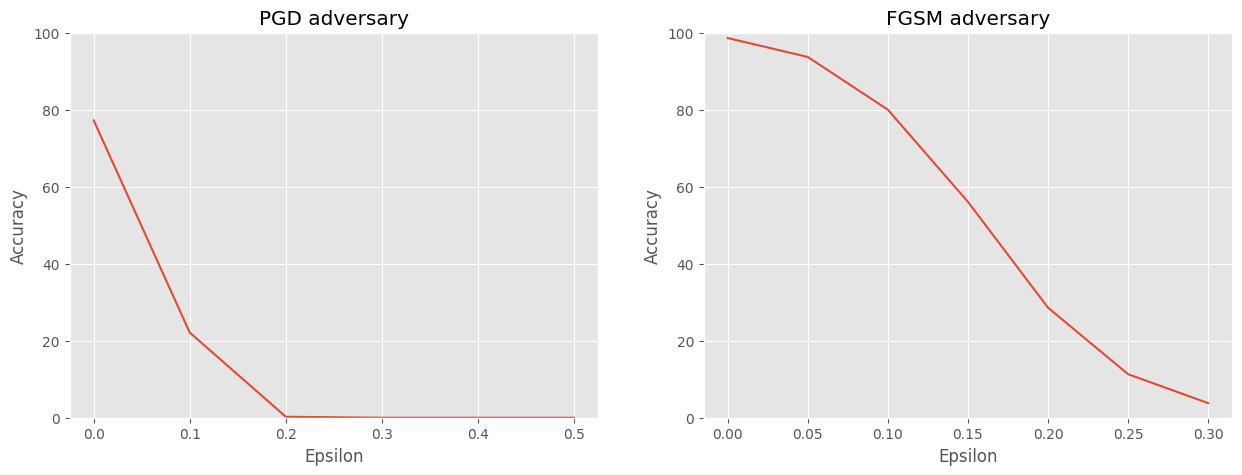

<Figure size 600x200 with 0 Axes>

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(6,2))
    
    axes[0].set_title('PGD adversary')
    axes[0].plot(pgd_attack_range, pgd_acc)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,100))
    
    axes[1].set_title('FGSM adversary')
    axes[1].plot(fgsm_attack_range, fgsm_acc)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,100))
    
    plt.show()

# 3. Defence against attak

In this phase we should load our trained model and evaluate its performance on protected testset (First we attack the testset and after that we protect them using compression).

## Load the trained model

In [ ]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Load the trained model
model = LeNet()
model = torch.load('/content/drive/MyDrive/Task/MNIST_model/model_mnist_20230423-142700')
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Load MNIST test dataset

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

## Define defence algorithm (compression algorithm)

In this algorithm we compress image using `cv2`. We first encode the image using qualtiy parameter and after that decode the encoded image, and return this image as compressed image.


One of the reasons why image compression can be used as a defense strategy is that it can help to reduce the amount of noise in an image, which can in turn make it more difficult for an attacker to create effective adversarial examples. When an attacker tries to generate adversarial examples, they typically add small perturbations to an image that are often imperceptible to the human eye, but can cause the neural network to misclassify the image. By compressing an image, the perturbations that an attacker adds may be amplified, which can make them more noticeable and less effective.
Moreover, compression can remove some high-frequency components in the image, which are often used by attackers to create adversarial examples. Additionally, compression can make the image more robust to transformations such as rotations, translations, and scaling, which can also be used to create adversarial examples.


In [ ]:
def compress(image, quality):
    # Define the compression parameters
    compression_params = [cv2.IMWRITE_JPEG_QUALITY, quality]

    # encode the image
    result, compressed_image = cv2.imencode('.jpg', image, compression_params)

    # decode the image
    decompressed_image = cv2.imdecode(compressed_image, cv2.IMREAD_GRAYSCALE)

    return decompressed_image


## Define accuracy function

In [ ]:
# evaluation of model before applying attack
def calculate_compression_accuracy(model, dataloader, quality):
  model.eval()  # set the model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      images = images.cpu()
      compressed_data = np.zeros_like(images.numpy())
      for i in range(len(images)):
        compressed_data[i][0] = compress(images[i][0].numpy(), quality)
      
      compressed_data = torch.from_numpy(compressed_data)  
      compressed_data = compressed_data.to(device)

      outputs = model(compressed_data)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

## Calculate accuracy before and after applying defence 

In this section, we perform defense strategies on both the clean and attacked test sets and compare the evaluation of the model on both sets. As we can see, the performance of the model using the defense function on the clean test set decreased because some important features of the images were removed. On the other hand, the performance of the model on the protected attacked test set (using FGSM and PDG attack strategies) increased because some details of the images were removed, which may have been part of the attack performed by the attacker.

In [ ]:
# Evaluate the model accuracy on the clean test data
quality = 90
clean_accuracy = calculate_compression_accuracy(model, test_loader, quality)
print(f'Accuracy of model on compression of clean testset: {clean_accuracy:.2f}%')


######################################################### FGSM attack ######################################################### 
# Generate adversarial examples using the FGSM attack
epsilon = 0.1

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
adversarial_accuracy = calculate_compression_accuracy(model, adv_examples, quality)
print(f'Accuracy of model on protected attacked testset (FGSM attack): {adversarial_accuracy:.2f}%')


######################################################### PGD attack ######################################################### 
# Generate adversarial examples using the PGD attack
epsilon=0.3
alpha=0.01
num_iter=40

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
adversarial_accuracy = calculate_compression_accuracy(model, adv_examples, quality)
print(f'Accuracy of model on protected attacked testset (PGD attack): {adversarial_accuracy:.2f}%')

Accuracy of model on compression of clean testset: 94.61%
Accuracy of model on protected attacked testset (FGSM attack): 80.49%
Accuracy of model on protected attacked testset (PGD attack): 75.74%


## Calculate accuracy on compressed images of varying quality levels

In [ ]:
# Test model on compressed images of varying quality levels
quality_range = [90, 80, 70, 60, 50 , 40]

# Evaluate the model accuracy on the clean test data
for quality in quality_range:
  clean_accuracy = calculate_compression_accuracy(model, test_loader, quality)
  print(f"Accuracy of model on compression of clean testset (quality {quality}): {clean_accuracy:.2f}%")


######################################################### FGSM attack ######################################################### 
# Generate adversarial examples using the FGSM attack
epsilon = 0.1

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
for quality in quality_range:
  adversarial_accuracy = calculate_compression_accuracy(model, adv_examples, quality)
  print(f'Accuracy of model on protected attacked testset (FGSM attack) (quality {quality}): {adversarial_accuracy:.2f}%')


######################################################### PGD attack ######################################################### 
# Generate adversarial examples using the PGD attack
epsilon=0.3
alpha=0.01
num_iter=40

adv_examples = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_iter)
    adv_examples.append((adv_images, labels))

# Evaluate the model accuracy on the adversarial test data
for quality in quality_range:
  adversarial_accuracy = calculate_compression_accuracy(model, adv_examples, quality)
  print(f'Accuracy of model on protected attacked testset (PGD attack) (quality {quality}): {adversarial_accuracy:.2f}%')


Accuracy of model on compression of clean testset (quality 90): 94.61%
Accuracy of model on compression of clean testset (quality 80): 87.08%
Accuracy of model on compression of clean testset (quality 70): 52.84%
Accuracy of model on compression of clean testset (quality 60): 62.27%
Accuracy of model on compression of clean testset (quality 50): 47.98%
Accuracy of model on compression of clean testset (quality 40): 19.15%
Accuracy of model on protected attacked testset (FGSM attack) (quality 90): 80.49%
Accuracy of model on protected attacked testset (FGSM attack) (quality 80): 33.91%
Accuracy of model on protected attacked testset (FGSM attack) (quality 70): 10.03%
Accuracy of model on protected attacked testset (FGSM attack) (quality 60): 24.20%
Accuracy of model on protected attacked testset (FGSM attack) (quality 50): 11.91%
Accuracy of model on protected attacked testset (FGSM attack) (quality 40): 9.89%
Accuracy of model on protected attacked testset (PGD attack) (quality 90): 75

## Visualize natural image vs attack image vs compress image

In [ ]:
input, label = next(iter(test_loader))
adv_input = fgsm_attack(model, input.to(device), label.to(device), epsilon)
adv_input = adv_input.cpu()
protected_input = compress(adv_input[0][0].numpy(), quality)

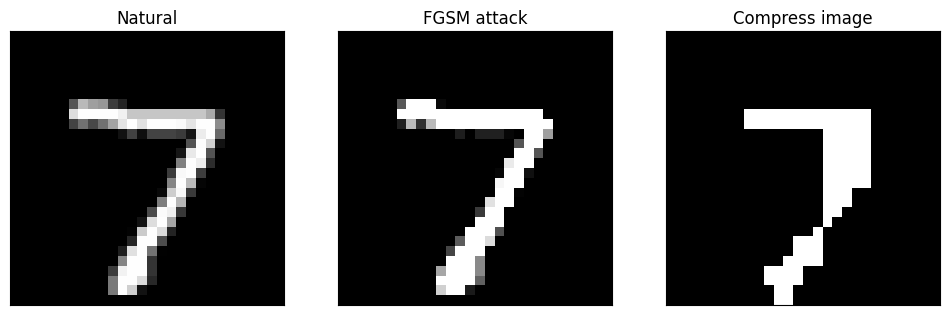

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))

axes[0].imshow(input[0][0], cmap='gray')
axes[0].set_title('Natural')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(adv_input.cpu()[0][0], cmap='gray')
axes[1].set_title('FGSM attack')
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(protected_input, cmap='gray')
axes[2].set_title('Compress image')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

# 4. Experiment (Ealuate empirically the effect of attack/defence)

## Load MNIST test dataset

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import cv2

train_dataset = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='data/', train=False, transform=ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145978031.67it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44551560.80it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34271017.82it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7759889.52it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
batch_size = 128 
learning_rate = 0.001
num_epochs = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
print(f'length of train_dataset is : {len(train_dataset)} and length of train_loader is : {len(train_loader)}')
print(f'length of test_dataset is : {len(test_dataset)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 60000 and length of train_loader is : 469
length of test_dataset is : 10000 and length of test_loader is : 10000


## Define required functions

In [ ]:
def train_model(model, train_loader, num_epochs, criterion, optimizer):
  train_loss = []

  for epoch in range(num_epochs):

    train_epoch_loss = 0
    loop = tqdm(enumerate(train_loader), total =len(train_loader), leave = False)
    
    for i , (img, label) in loop:

      # transfer tensor to device
      img = img.to(device)
      label = label.to(device)

      # forward pass
      y_pred = model(img)
      loss_train = criterion(y_pred, label)

      # backward pass
      optimizer.zero_grad()  # clear the gradients
      loss_train.backward()
      optimizer.step()       # update model weights

      train_epoch_loss += loss_train.item()
    
    train_loss.append(train_epoch_loss/len(train_loader))

    # Upgrade progress bar
    loop.set_description(f'Epoch : [{epoch + 1}/{num_epochs}]')
    loop.set_postfix(loss = loss_train.item())

  return train_loss


# evaluation of model 
def test_model(model, dataloader):
  model.eval()  # set the model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy  


def apply_fgsm_attack(model, test_loader, epsilon): #TODO

  num_perturbations = int(len(test_dataset) * 0.6)
  perturbation_indices = list(np.random.choice(len(test_dataset), num_perturbations, replace=False))

  adv_examples = []
  for i, (images, labels) in enumerate(test_loader): # portion of test data TODO
      images = images.to(device)
      labels = labels.to(device)
      if i in perturbation_indices:
        adv_images = fgsm_attack(model, images, labels, epsilon)
        adv_examples.append((adv_images, labels))  
      else:
          adv_examples.append((images, labels)) 
      # adv_images = fgsm_attack(model, images, labels, epsilon)
      # adv_examples.append((adv_images, labels)) 

  return adv_examples


def apply_defence(adv_examples, quality):

  compress_examples = []
  for images, labels in adv_examples:
      images = images.to(device)
      labels = labels.to(device)

      images = images.cpu()
      compressed_data = np.zeros_like(images.numpy())
      for i in range(len(images)):
        compressed_data[i][0] = compress(images[i][0].numpy(), quality)
      
      compressed_data = torch.from_numpy(compressed_data)  
      compressed_data = compressed_data.to(device)
      compress_examples.append((compressed_data, labels))  

  return compress_examples




In the following function we will use all of the previous functions in order to:


1.   Train digit classfier
2.   Test model on clean test set
3.   Attack to a portion of test set
4.   Test model on attacked test set
5.   Apply compression algorithm to attacked test set
6.   Test model on protected test set
7.   Save accuracies of modol in steps 4 and 6 in different runs in order to applying statistic test (Wilcoxon)






In [ ]:
def experiment(dataloader, attack_epsilon, defence_quality):
  
  # Set the device to GPU if available, otherwise use CPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = LeNet()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)

  model = model.to(device)
  criterion = criterion.to(device)

  train_loss = train_model(model, train_loader, num_epochs, criterion, optimizer)

  # Compute initial accuracy without attack or defence
  acc_clean = test_model(model, dataloader)
  print(f"Accuracy without attack or defence : {acc_clean}")

  # Generate attacked test set and compute accuracy with attack only
  attacked_test_set = apply_fgsm_attack(model, dataloader, attack_epsilon) # attack portion of test dataset
  acc_attack_only = test_model(model, attacked_test_set)
  # no_defence_acc.append(acc_attack_only)
  print(f"Accuracy with attack only (no defence): {acc_attack_only}")
  
  # Apply defence and compute restored accuracy
  jpeg_defence_test_set = apply_defence(attacked_test_set, defence_quality)
  acc_jpeg_defence = test_model(model, jpeg_defence_test_set)
  # jpeg_defence_acc.append(acc_jpeg_defence)
  print(f"Accuracy with JPEG defence: {acc_jpeg_defence}\n\n")

  return acc_attack_only, acc_jpeg_defence

## Run experiments

### Experiment 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Set up hyperparameters for experiments
num_runs = 20
attack_epsilons = [0.05, 0.1, 0.15] # Varying levels of attack strength
defence_quality = [75, 85, 95] # Varying levels of defence strength

# Define lists to store accuracy values for each experiment
no_defence_acc = []
jpeg_defence_acc = []

# Run experiments
for i in range(num_runs):
    print(f"Running experiment {i+1}...")

    acc_attack_only, acc_jpeg_defence = experiment(test_loader, attack_epsilons[0], defence_quality[0])
    no_defence_acc.append(acc_attack_only)
    jpeg_defence_acc.append(acc_jpeg_defence)


Running experiment 1...


Accuracy without attack or defence : 13.64
Accuracy with attack only (no defence): 12.63
Accuracy with JPEG defence: 11.55


Running experiment 2...


Accuracy without attack or defence : 11.09
Accuracy with attack only (no defence): 10.47
Accuracy with JPEG defence: 10.54


Running experiment 3...


Accuracy without attack or defence : 31.35
Accuracy with attack only (no defence): 24.23
Accuracy with JPEG defence: 15.23


Running experiment 4...


Accuracy without attack or defence : 21.26
Accuracy with attack only (no defence): 13.29
Accuracy with JPEG defence: 12.89


Running experiment 5...


Accuracy without attack or defence : 31.56
Accuracy with attack only (no defence): 25.4
Accuracy with JPEG defence: 14.08


Running experiment 6...


Accuracy without attack or defence : 20.94
Accuracy with attack only (no defence): 20.48
Accuracy with JPEG defence: 13.46


Running experiment 7...


Accuracy without attack or defence : 43.4
Accuracy with attack only (no defence): 37.64
Accuracy with JPEG defence: 16.49


Running experiment 8...


Accuracy without attack or defence : 24.53
Accuracy with attack only (no defence): 19.21
Accuracy with JPEG defence: 10.97


Running experiment 9...


Accuracy without attack or defence : 11.36
Accuracy with attack only (no defence): 11.36
Accuracy with JPEG defence: 11.35


Running experiment 10...


Accuracy without attack or defence : 50.2
Accuracy with attack only (no defence): 42.55
Accuracy with JPEG defence: 19.93


Running experiment 11...


Accuracy without attack or defence : 15.52
Accuracy with attack only (no defence): 13.55
Accuracy with JPEG defence: 11.61


Running experiment 12...


Accuracy without attack or defence : 29.93
Accuracy with attack only (no defence): 25.2
Accuracy with JPEG defence: 13.61


Running experiment 13...


Accuracy without attack or defence : 52.85
Accuracy with attack only (no defence): 46.6
Accuracy with JPEG defence: 17.34


Running experiment 14...


Accuracy without attack or defence : 47.56
Accuracy with attack only (no defence): 43.11
Accuracy with JPEG defence: 22.64


Running experiment 15...


Accuracy without attack or defence : 22.68
Accuracy with attack only (no defence): 20.42
Accuracy with JPEG defence: 12.24


Running experiment 16...


Accuracy without attack or defence : 33.08
Accuracy with attack only (no defence): 28.26
Accuracy with JPEG defence: 13.49


Running experiment 17...


Accuracy without attack or defence : 20.73
Accuracy with attack only (no defence): 19.58
Accuracy with JPEG defence: 15.68


Running experiment 18...


Accuracy without attack or defence : 25.0
Accuracy with attack only (no defence): 22.26
Accuracy with JPEG defence: 12.64


Running experiment 19...


Accuracy without attack or defence : 11.63
Accuracy with attack only (no defence): 11.47
Accuracy with JPEG defence: 11.35


Running experiment 20...


Accuracy without attack or defence : 16.96
Accuracy with attack only (no defence): 12.07
Accuracy with JPEG defence: 6.53




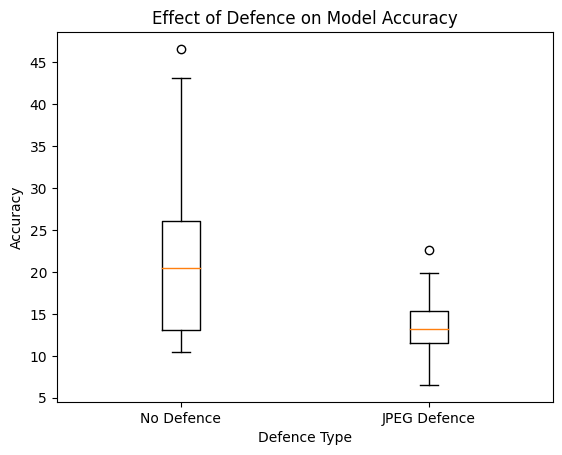

In [ ]:
# Display boxplots of accuracy values
fig, ax = plt.subplots()
ax.boxplot([no_defence_acc, jpeg_defence_acc], labels=['No Defence', 'JPEG Defence'])
ax.set_xlabel('Defence Type')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Defence on Model Accuracy')
plt.show()

The data points out of the lower and upper whiskers are outliers, so, in this figure we have two outliers. As a result we can use wilcoxon test.

In [ ]:
# Test for statistical significance
wilcoxon_result = wilcoxon(no_defence_acc, jpeg_defence_acc)
print(f"Wilcoxon test result: {wilcoxon_result}")

Wilcoxon test result: WilcoxonResult(statistic=2.0, pvalue=5.7220458984375e-06)


In [ ]:
p_value = wilcoxon_result.pvalue
if p_value < 0.05:
    print('The difference in accuracy is statistically significant. (These two lists are not from same population)')
else:
    print('The difference in accuracy is not statistically significant. (These two lists are from same population)')

The difference in accuracy is statistically significant. (These two lists are not from same population)


### Experiment 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Set up hyperparameters for experiments
num_runs = 20
attack_epsilons = [0.05, 0.1, 0.15] # Varying levels of attack strength
defence_quality = [75, 85, 95] # Varying levels of defence strength

# Define lists to store accuracy values for each experiment
no_defence_acc = []
jpeg_defence_acc = []

# Run experiments
for i in range(num_runs):
    print(f"Running experiment {i+1}...")

    acc_attack_only, acc_jpeg_defence = experiment(test_loader, attack_epsilons[0], defence_quality[2])
    no_defence_acc.append(acc_attack_only)
    jpeg_defence_acc.append(acc_jpeg_defence)


Running experiment 1...


Accuracy without attack or defence : 18.68
Accuracy with attack only (no defence): 17.48
Accuracy with JPEG defence: 18.16


Running experiment 2...


Accuracy without attack or defence : 24.39
Accuracy with attack only (no defence): 22.49
Accuracy with JPEG defence: 23.19


Running experiment 3...


Accuracy without attack or defence : 19.34
Accuracy with attack only (no defence): 15.04
Accuracy with JPEG defence: 19.64


Running experiment 4...


Accuracy without attack or defence : 11.35
Accuracy with attack only (no defence): 11.35
Accuracy with JPEG defence: 11.35


Running experiment 5...


Accuracy without attack or defence : 22.83
Accuracy with attack only (no defence): 18.71
Accuracy with JPEG defence: 23.44


Running experiment 6...


Accuracy without attack or defence : 10.15
Accuracy with attack only (no defence): 10.12
Accuracy with JPEG defence: 11.04


Running experiment 7...


Accuracy without attack or defence : 44.66
Accuracy with attack only (no defence): 38.86
Accuracy with JPEG defence: 44.43


Running experiment 8...


Accuracy without attack or defence : 10.17
Accuracy with attack only (no defence): 10.11
Accuracy with JPEG defence: 10.37


Running experiment 9...


Accuracy without attack or defence : 20.26
Accuracy with attack only (no defence): 17.39
Accuracy with JPEG defence: 24.97


Running experiment 10...


Accuracy without attack or defence : 23.79
Accuracy with attack only (no defence): 16.15
Accuracy with JPEG defence: 21.61


Running experiment 11...


Accuracy without attack or defence : 25.41
Accuracy with attack only (no defence): 23.4
Accuracy with JPEG defence: 25.75


Running experiment 12...


Accuracy without attack or defence : 20.61
Accuracy with attack only (no defence): 11.27
Accuracy with JPEG defence: 21.19


Running experiment 13...


Accuracy without attack or defence : 23.91
Accuracy with attack only (no defence): 20.27
Accuracy with JPEG defence: 25.41


Running experiment 14...


Accuracy without attack or defence : 21.43
Accuracy with attack only (no defence): 18.04
Accuracy with JPEG defence: 22.96


Running experiment 15...


Accuracy without attack or defence : 32.79
Accuracy with attack only (no defence): 29.58
Accuracy with JPEG defence: 33.89


Running experiment 16...


Accuracy without attack or defence : 20.82
Accuracy with attack only (no defence): 20.03
Accuracy with JPEG defence: 20.21


Running experiment 17...


Accuracy without attack or defence : 17.13
Accuracy with attack only (no defence): 12.82
Accuracy with JPEG defence: 14.84


Running experiment 18...


Accuracy without attack or defence : 10.32
Accuracy with attack only (no defence): 10.3
Accuracy with JPEG defence: 10.37


Running experiment 19...


Accuracy without attack or defence : 10.28
Accuracy with attack only (no defence): 10.28
Accuracy with JPEG defence: 10.28


Running experiment 20...


Accuracy without attack or defence : 38.24
Accuracy with attack only (no defence): 25.78
Accuracy with JPEG defence: 33.86




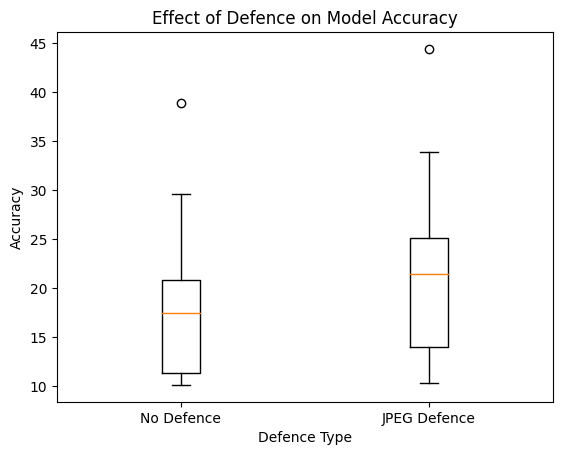

In [ ]:
# Display boxplots of accuracy values
fig, ax = plt.subplots()
ax.boxplot([no_defence_acc, jpeg_defence_acc], labels=['No Defence', 'JPEG Defence'])
ax.set_xlabel('Defence Type')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Defence on Model Accuracy')
plt.show()

In [ ]:
# Test for statistical significance
wilcoxon_result = wilcoxon(no_defence_acc, jpeg_defence_acc)
print(f"Wilcoxon test result: {wilcoxon_result}")

Wilcoxon test result: WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)


In [ ]:
p_value = wilcoxon_result.pvalue
if p_value < 0.05:
    print('The difference in accuracy is statistically significant. (These two lists are not from same population)')
else:
    print('The difference in accuracy is not statistically significant. (These two lists are from same population)')

The difference in accuracy is statistically significant. (These two lists are not from same population)


### Experiment 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Set up hyperparameters for experiments
num_runs = 20
attack_epsilons = [0.05, 0.1, 0.15] # Varying levels of attack strength
defence_quality = [75, 85, 95] # Varying levels of defence strength

# Define lists to store accuracy values for each experiment
no_defence_acc = []
jpeg_defence_acc = []

# Run experiments
for i in range(num_runs):
    print(f"Running experiment {i+1}...")

    acc_attack_only, acc_jpeg_defence = experiment(test_loader, attack_epsilons[2], defence_quality[0])
    no_defence_acc.append(acc_attack_only)
    jpeg_defence_acc.append(acc_jpeg_defence)


Running experiment 1...


Accuracy without attack or defence : 21.46
Accuracy with attack only (no defence): 10.71
Accuracy with JPEG defence: 12.39


Running experiment 2...


Accuracy without attack or defence : 20.41
Accuracy with attack only (no defence): 13.28
Accuracy with JPEG defence: 11.91


Running experiment 3...


Accuracy without attack or defence : 27.86
Accuracy with attack only (no defence): 19.23
Accuracy with JPEG defence: 12.73


Running experiment 4...


Accuracy without attack or defence : 32.7
Accuracy with attack only (no defence): 22.49
Accuracy with JPEG defence: 16.32


Running experiment 5...


Accuracy without attack or defence : 11.64
Accuracy with attack only (no defence): 11.5
Accuracy with JPEG defence: 11.61


Running experiment 6...


Accuracy without attack or defence : 20.14
Accuracy with attack only (no defence): 9.53
Accuracy with JPEG defence: 14.57


Running experiment 7...


Accuracy without attack or defence : 28.94
Accuracy with attack only (no defence): 18.12
Accuracy with JPEG defence: 13.03


Running experiment 8...


Accuracy without attack or defence : 36.07
Accuracy with attack only (no defence): 24.71
Accuracy with JPEG defence: 15.67


Running experiment 9...


Accuracy without attack or defence : 33.48
Accuracy with attack only (no defence): 22.93
Accuracy with JPEG defence: 13.17


Running experiment 10...


Accuracy without attack or defence : 27.25
Accuracy with attack only (no defence): 18.63
Accuracy with JPEG defence: 12.17


Running experiment 11...


Accuracy without attack or defence : 33.1
Accuracy with attack only (no defence): 20.91
Accuracy with JPEG defence: 15.11


Running experiment 12...


Accuracy without attack or defence : 24.63
Accuracy with attack only (no defence): 19.48
Accuracy with JPEG defence: 12.58


Running experiment 13...


Accuracy without attack or defence : 27.93
Accuracy with attack only (no defence): 16.4
Accuracy with JPEG defence: 14.98


Running experiment 14...


Accuracy without attack or defence : 28.93
Accuracy with attack only (no defence): 17.93
Accuracy with JPEG defence: 15.0


Running experiment 15...


Accuracy without attack or defence : 17.9
Accuracy with attack only (no defence): 14.18
Accuracy with JPEG defence: 13.95


Running experiment 16...


Accuracy without attack or defence : 33.47
Accuracy with attack only (no defence): 25.45
Accuracy with JPEG defence: 12.91


Running experiment 17...


Accuracy without attack or defence : 28.9
Accuracy with attack only (no defence): 18.47
Accuracy with JPEG defence: 17.81


Running experiment 18...


Accuracy without attack or defence : 11.35
Accuracy with attack only (no defence): 11.35
Accuracy with JPEG defence: 11.35


Running experiment 19...


Accuracy without attack or defence : 47.72
Accuracy with attack only (no defence): 34.56
Accuracy with JPEG defence: 17.75


Running experiment 20...


Accuracy without attack or defence : 27.59
Accuracy with attack only (no defence): 21.65
Accuracy with JPEG defence: 14.9




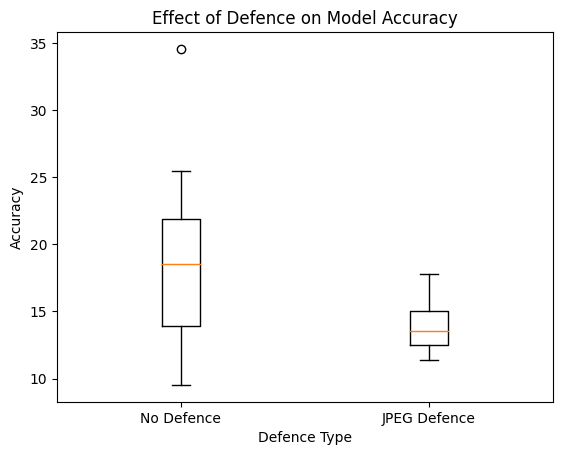

In [ ]:
# Display boxplots of accuracy values
fig, ax = plt.subplots()
ax.boxplot([no_defence_acc, jpeg_defence_acc], labels=['No Defence', 'JPEG Defence'])
ax.set_xlabel('Defence Type')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Defence on Model Accuracy')
plt.show()

In [ ]:
# Test for statistical significance
wilcoxon_result = wilcoxon(no_defence_acc, jpeg_defence_acc)
print(f"Wilcoxon test result: {wilcoxon_result}")

Wilcoxon test result: WilcoxonResult(statistic=15.0, pvalue=0.001284705613291876)


In [ ]:
p_value = wilcoxon_result.pvalue
if p_value < 0.05:
    print('The difference in accuracy is statistically significant. (These two lists are not from same population)')
else:
    print('The difference in accuracy is not statistically significant. (These two lists are from same population)')

The difference in accuracy is statistically significant. (These two lists are not from same population)
